# Food Recognizer

## Description

Dans ce projet nous avons effectuer une classification multi-classe sur 58 types d'aliments; le modèle est entraîîné avec une d'architecture Deep Learning "Inception V3".

## Ressources

* Kernel kaggle : https://www.kaggle.com/theimgclist/multiclass-food-classification-using-tensorflow
* Comprendre l'architecture InceptionV3 : https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/
* Mount Drive in Colab : https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
* Recognizing Animals in Photos: Building an AI model for Object Recognition : https://appsilon.com/object-recognition-transfer-learning/
* !!! yolo-for-real-time-food-detection : http://bennycheung.github.io/yolo-for-real-time-food-detection
* Downloading datasets into google drive via google colab : https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

## TODO

* Décrire plus précision le modèle Inception V3 et son architecture : Dropout, ...
* Décrire plus précisément l'évaluation du modèle

# Notebook content

0. Importing Necessary Modules
1. Mount Google Drive to Google Colag
2. Dataset structure
3. Inception pretrained with Food 58 dataset
4. Accuracy and loss plot
5. Predicting classes from new images from the internet using the best train model
6. Object detection test

## 0. Importing Necessary Modules

In [0]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import shutil
from collections import defaultdict
import random
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

## 1. Mount Google Drive to Google Colag

Nous lions notre notebook à Google Drive pour pouvoir utiliser les systèmes de fichiers de Google Drive.

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# On se place dans le dossier de travail courant du projet
from google.colab import drive

root_path = '/content/gdrive/My Drive/Portfolio_data/Projet-Food-Reconizer/'  #change dir to your project folder
dataset_file_path = root_path + "g_img_dataset.zip"
# Change path to the working directory
os.chdir(root_path)

## 2. Dataset structure

**The dataset has been build by scraping Google Images**

*   This is a dataset of 29000 (21750 for training and 7250 for validation) food images
*   We have 58 food type categories
*   We have a train and test folder who each contains 58 folder (58 categories) with 375 images train folder and 125 images for test folder.



In [0]:
#Unzip the images dataset - Uncomment and execute if the dataset has not been unzip
# !jar xvf g_img_dataset.zip

In [5]:
# sample of food classes.
os.listdir("src/g_img_dataset/test")[:10]

['steak',
 'pulled_pork',
 'beef_carpaccio',
 'filet_mignon',
 'baby_back_ribs',
 'beef_tartare',
 'chicken_curry',
 'chicken_wings',
 'peking_duck',
 'pork_chop']

**"meta"** folder contains the text and json files :
<br>
* **food_classes.txt :** contains the list of all classes of food
* **food_labels.txt :** contains the list of all labels of food
* **train.txt :** contains the list of images that belong to training set  
* **test.txt :** contains the list of images that belong to test set  
* **train.json :** contains the list of images that belong to training set in json format
* **test.json :** contains the list of images that belong to test set in json format



In [6]:
!ls -la src/g_img_dataset/meta/ | awk '{print $8,$9}'

 
16:30 food_classes.txt
14:29 food_labels.txt
08:56 test.json
08:47 test.txt
09:00 train.json
08:47 train.txt


In [7]:
!head src/g_img_dataset/meta/train.json

  {"type":"directory","name":"train","contents":[
    {"type":"directory","name":"almonds","contents":[
      {"type":"file","name":"0079effae1.jpg"},
      {"type":"file","name":"008aa0051f.jpg"},
      {"type":"file","name":"00919ad24d.jpg"},
      {"type":"file","name":"04d58d03c2.jpg"},
      {"type":"file","name":"0505784391.jpg"},
      {"type":"file","name":"05e3c0a3b7.jpg"},
      {"type":"file","name":"065f067e49.jpg"},
      {"type":"file","name":"074de20f1d.jpg"},


In [8]:
!head src/g_img_dataset/meta/train.txt

green_beans/3405b582f4.jpg
green_beans/459944d323.jpg
green_beans/64386f633f.jpg
green_beans/3c095b8805.jpg
green_beans/6a6ca6227d.jpg
green_beans/85801796fc.jpg
green_beans/1a748f420f.jpg
green_beans/3582e7b806.jpg
green_beans/5dc45fd661.jpg
green_beans/12cabb101f.jpg


In [9]:
!head src/g_img_dataset/meta/food_classes.txt

['blackberries',
 'cantaloupe',
 'blueberries',
 'cherries',
 'peach',
 'kiwi',
 'clementine',
 'plum',
 'raspberries',
 'strawberries',


In [10]:
!head src/g_img_dataset/meta/food_labels.txt

'Blackberries',
 'Cantaloupe',
 'Blueberries',
 'Cherries',
 'Peach',
 'Kiwi',
 'Clementine',
 'Plum',
 'Raspberries',
 'Strawberries',


**Liste de modèles entrainés**<br>
Le dataset contient une liste de modèles entrainés<br>

In [11]:
!find src/g_img_dataset/trained_models/

src/g_img_dataset/trained_models/
src/g_img_dataset/trained_models/best_model_58class_all.hdf5
src/g_img_dataset/trained_models/model_trained_58class_all.hdf5


**Visualize some images**

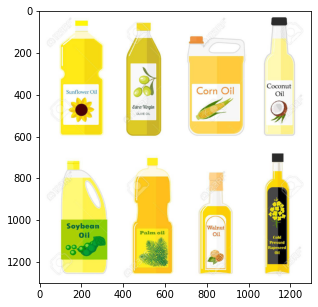

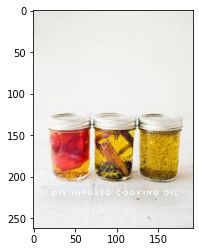

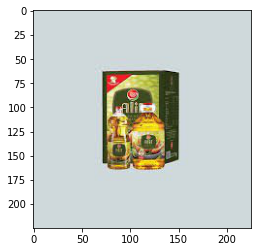

In [12]:
lst_images = os.listdir("src/g_img_dataset/train")
idx = np.random.randint(len(lst_images))
food_type = lst_images[idx]
lst_food_type_images = os.listdir(f"src/g_img_dataset/train/{food_type}")
image_path = f"src/g_img_dataset/train/{food_type}"

plt.figure(figsize=(5, 5))
for i in range(3):
  img = plt.imread(f"{image_path}/{lst_food_type_images[np.random.randint(len(lst_food_type_images))]}")
  plt.imshow(img)
  plt.show()
  

In [13]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find src/g_img_dataset/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
1
21750


In [0]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find src/g_img_dataset/test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
7250


## 3. Inception pretrained with Food 58 dataset

In [0]:
## A dé-commenter pour entrainer le modèle
# K.clear_session()
# n_classes = 58
# img_width, img_height = 299, 299
# train_data_dir = "src/g_img_dataset/train"
# validation_data_dir = "src/g_img_dataset/test"
# nb_train_samples = 21750
# nb_validation_samples = 7250
# batch_size = 16

# # augmentation configuration use for training
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(  
#         train_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode="categorical")

# validation_generator = test_datagen.flow_from_directory(  
#         validation_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode="categorical")

# inception = InceptionV3(weights='imagenet', include_top=False)
# x = inception.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation="relu")(x)
# x = Dropout(0.2)(x)
# predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation="softmax")(x)

# model = Model(inputs=inception.input, outputs=predictions)
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
#               loss="categorical_crossentropy",
#               metrics=["accuracy"])
# checkpointer = ModelCheckpoint(filepath="best_model_58class_all.hdf5", verbose=1, save_best_only=True)
# csv_logger = CSVLogger("history_58class_all.log")
# earlyStopping = [EarlyStopping(monitor="val_loss", patience=10)]

# history = model.fit_generator(
#     train_generator, 
#     steps_per_epoch=nb_train_samples // batch_size,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples // batch_size,
#     epochs=30,
#     verbose=1,
#     callbacks=[csv_logger, checkpointer, earlyStopping]
# )

# model.save("model_trained_101class_58class_all.hdf5")

## 4. Accuracy and loss plot

In [14]:
df_history = pd.read_csv("src/history_58class_all.log")
df_history.tail(5)

,epoch,accuracy,loss,val_accuracy,val_loss
25,25,0.899328,0.676142,0.844647,0.865736
26,26,0.907058,0.649580,0.848234,0.855357
27,27,0.913960,0.615745,0.849890,0.840163
28,28,0.920171,0.595836,0.854581,0.831913
29,29,0.925278,0.577421,0.854305,0.825411


In [0]:
def plot_accuracy(history, title):
  plt.title(title)
  plt.plot(history["accuracy"])
  plt.plot(history["val_accuracy"])
  plt.ylabel("accuracy")
  plt.xlabel("epoch")
  plt.legend(["train_accuracy", "validation_accuracy"], loc="best")
  plt.show()

def plot_loss(history, title):
  plt.title(title)
  plt.plot(history["loss"])
  plt.plot(history["val_loss"])
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.legend(["train_loss", "validation_loss"], loc="best")
  plt.show()  

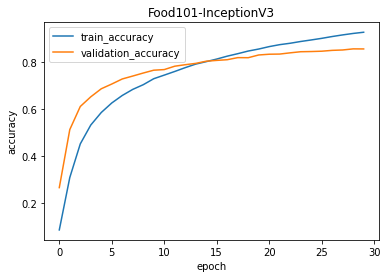

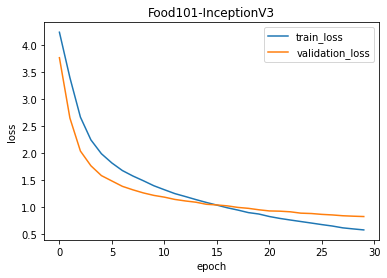

In [0]:
plot_accuracy(df_history, "Food101-InceptionV3")
plot_loss(df_history, "Food101-InceptionV3")

* Accuracy increased with epochs and the loss decreased
* Validation accuracy has been on higher side than training accuracy for many epochs; this could be for several reason : 
  * due to the used of pre-trained model on ImageNet ...
  * Using Dropout can lead to a higher validation accuracy

## 5. Predicting classes from new images from the internet using the best train model

In [0]:
# Load the best save model to make predictions
K.clear_session()
model_best = load_model("src/best_model_58class_all.hdf5", compile=False)

* clearing session and set compile=False leads to faster loading
* 

In [0]:
# Download validation images
# !wget -O src/g_img_dataset/validation/sarvice.jpg https://p1.storage.canalblog.com/13/02/410020/86561910_p.jpg

--2020-05-09 10:51:34--  https://p1.storage.canalblog.com/13/02/410020/86561910_p.jpg
Resolving p1.storage.canalblog.com (p1.storage.canalblog.com)... 195.137.184.178, 195.137.184.180
Connecting to p1.storage.canalblog.com (p1.storage.canalblog.com)|195.137.184.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40409 (39K) [image/jpeg]
Saving to: ‘src/g_img_dataset/sarvice.jpg’

src/g_img_dataset/s 100%[===================>]  39.46K  --.-KB/s    in 0.1s    

2020-05-09 10:51:34 (386 KB/s) - ‘src/g_img_dataset/sarvice.jpg’ saved [40409/40409]



In [0]:
def predict_class(model, images, show=True):
  for img in images:
    # print(img)
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list = os.listdir("src/g_img_dataset/test")
    food_list.sort()
    pred_value = food_list[index]
    if show:
      plt.imshow(img[0])
      plt.axis("off")
      plt.title(pred_value)
      plt.show()

In [0]:
images = []
for file_name in os.listdir("src/g_img_dataset/validation"):
    images.append(f'src/g_img_dataset/validation/{file_name}')

print(images)    
predict_class(model_best, images, True)

Output hidden; open in https://colab.research.google.com to view.

## 6. Object detection test

In [0]:
!apt-get install protobuf-compiler

In [0]:
# II.1. Setting the paths to the trained graph
# First, we set the paths of the model we will use in a variable called PATH_TO_CKPT: this is the path to the frozen_inference_graph.pb that you downloaded in I.2.

### TODO: define the variable PATH_TO_CKPT
### STRIP_START ###
PATH_TO_CKPT = 'data/models/frozen_inference_graph.pb'

In [0]:
# Next you have to set the paths to the labels: indeed labels are just numbers, but we want them to be strings so that we can understand! 
# The table to do so is in the folder you cloned: models/research/object_detection/data/mscoco_label_map.pbtxt.
# Put that path into the variable PATH_TO_LABELS:

PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxtss'

In [0]:
# variable NUM_CLASSES
NUM_CLASSES = 90

In [0]:
# II.2. Testing object detection
# We made some utils functions for you, so that you will just have to put them together to do the object detection.
# First, with the following code, you will compute the graph with the trained weights you downloaded:

import tensorflow.compat.v1 as tf

# Compute the graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

def run_inference_for_single_image(image, graph):
    """Computes the prediction of the object detection on a single image

    Parameters:
    image (np.array): An image in shape [height, width, 3]
	graph: a graph object from TensorFlow

    Returns:
    dict: a dict containing the number of detections, their classes, boxes and scores

    """

    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores',
                        'detection_classes']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)

            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
 
            # Run inference
            output_dict = sess.run(tensor_dict,
                    feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
    return output_dict


In [0]:
import pathlib

PATH_TO_TEST_IMAGES_DIR = pathlib.Path('input')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

In [0]:
### TODO: Use run_inference_for_single_image to compute the object detection
from matplotlib import image
import matplotlib.pyplot as plt
img = image.imread("input/image1.jpg")
plt.imshow(img)
plt.show()

In [0]:
# Now have a look at the output dictionary, can you understand its content? Save them in pickle format, in the next part of the challenge we will display and post process them!
output_dicts = []

for image_path in TEST_IMAGE_PATHS:
    image_np = plt.imread(image_path)
    output_dicts.append(run_inference_for_single_image(image_np, detection_graph))
    
output_dicts

In [0]:
import pickle
with open('data/models/detection_boxes.pkl','wb') as f:
    pickle.dump(output_dicts, f)

In [0]:
# Then, you will have to use the functions run_inference_for_single_image provided in the utils.py file. 
# This function is easy to find on the TensorFlow Object Detection API. Have a look at it and try to understand the big picture.
# Then use it on the provided test images: image1.jpg, image2 and image3.jpg.
### TODO: Use run_inference_for_single_image to compute the object detection
import sys
sys.path.append('input')
from utils import run_inference_for_single_image
import numpy as np
import matplotlib.pyplot as plt

im1 = plt.imread('input/image1.jpg')
im2 = plt.imread('input/image2.jpg')
im3 = plt.imread('input/image3.jpg')

output_dict1 = run_inference_for_single_image(im1, detection_graph)
output_dict2 = run_inference_for_single_image(im2, detection_graph)
output_dict3 = run_inference_for_single_image(im3, detection_graph)

In [0]:
# Now have a look at the output dictionary, can you understand its content? Save them in pickle format, in the next part of the challenge we will display and post process them!
import pickle

pickle.dump(output_dict1, open("input/output_im1.p", "wb"))
pickle.dump(output_dict2, open("input/output_im2.p", "wb"))
pickle.dump(output_dict3, open("input/output_im3.p", "wb"))

In [0]:
import pickle

dict1 = pickle.load(open("input/output_im1.p", "rb"))
dict2 = pickle.load(open("input/output_im2.p", "rb"))
dict3 = pickle.load(open("input/output_im3.p", "rb"))

import matplotlib.pyplot as plt

im1 = plt.imread('input/image1.jpg')
im2 = plt.imread('input/image2.jpg')
im3 = plt.imread('input/image3.jpg')

In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
import matplotlib.pyplot as plt
from PIL import Image

# Here the notebook is store in object_detection folder
sys.path.append('models/research/')
import object_detection
from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util
# from label_map_util import load_labelmap, convert_label_map_to_categories, create_category_index

ModuleNotFoundError: ignored

In [0]:
sys.path.append('input')
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
NUM_CLASSES=90

In [0]:
# !ls -l models/research/object_detection/utils/

In [0]:
import pickle

dict1 = pickle.load(open("input/output_im1.p", "rb"))
dict2 = pickle.load(open("input/output_im2.p", "rb"))
dict3 = pickle.load(open("input/output_im3.p", "rb"))

import matplotlib.pyplot as plt

im1 = plt.imread('input/image1.jpg')
im2 = plt.imread('input/image2.jpg')
im3 = plt.imread('input/image3.jpg')

In [0]:
import sys
sys.path.append('models/research/')
#from object_detection.utils import label_map_util
sys.path.append('input')
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
NUM_CLASSES=90

In [0]:
# import tensorflow.compat.v1 as tf
import tensorflow as tf

# patch tf1 into `utils.ops`
# utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [0]:
# Here we use those functions for you
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def tf_box_to_matplotlib(box, im):
    x = box[1]*im.shape[1]
    y = box[0]*im.shape[0]
    width = (box[3]-box[1])*im.shape[1]
    height = (box[2]-box[0])*im.shape[0]
    
    return x, y, width, height

def display_image_with_boxes(image, dico, threshold=0):

    fig, ax = plt.subplots(1, figsize=(14,10))
    plt.imshow(image)

    for i in range(dico['num_detections']):
        score = dico['detection_scores'][i]
        clas = category_index[dico['detection_classes'][i]]['name']

        if score >= threshold:

            display = str("{:.2f}".format(score))+' '+clas

            x, y, w, h = tf_box_to_matplotlib(dico['detection_boxes'][i], image)
            ax.add_patch(Rectangle((x, y), w, h,linewidth=1,edgecolor='r',facecolor='none'))
            plt.text(x, y-10, display, color='red', fontsize=10)

    plt.axis('off')
    plt.show()

In [0]:
### TODO: use display_image_with_boxes and display the result
### STRIP_START ###
display_image_with_boxes(im1, dict1)

print('number of detected object:', dict1['num_detections'])

In [0]:
display_image_with_boxes(im2, dict2)

print('number of detected object:', dict2['num_detections'])

In [0]:
display_image_with_boxes(im3, dict3)

print('number of detected object:', dict3['num_detections'])

In [0]:
def intersect(box1, box2):
    xx1 = max(box1[1], box2[1])
    yy1 = max(box1[0], box2[0])
    xx2 = min(box1[3], box2[3])
    yy2 = min(box1[2], box2[2])
    
    return max(0, (xx2-xx1))*max(0, (yy2-yy1))

In [0]:
def union(box1, box2):
    un = np.abs((box1[2]-box1[0])*(box1[3]-box1[1])) + \
         np.abs((box2[2]-box2[0])*(box2[3]-box2[1])) - \
         intersect(box1, box2)
    return un

In [0]:
def iou(box1, box2):
    return intersect(box1, box2)/union(box1, box2)

In [0]:
def apply_detection_threshold(detections, detection_threshold):
    picks = []
    
    for i in range(len(detections['detection_scores'])):
        if detections['detection_scores'][i] >= detection_threshold:
            picks.append(i)

    
    output = {'detection_scores': detections['detection_scores'][picks],
              'detection_boxes': detections['detection_boxes'][picks],
              'detection_classes': detections['detection_classes'][picks],
              'num_detections': len(detections['detection_scores'][picks])}
    
    return output

In [0]:
import numpy as np

def non_max_suppression(detections, iou_threshold, detection_threshold):
    
    detections = apply_detection_threshold(detections, detection_threshold)
    
    indices = np.arange(len(detections['detection_boxes']))
    
    
    output_scores = []
    output_boxes = []
    output_classes = []
    
    while len(indices)>0:
        # Get the highest score
        highest_score_idx = detections['detection_scores'].argmax()
        
        # Save the highest score
        output_scores.append(detections['detection_scores'][highest_score_idx])
        output_boxes.append(detections['detection_boxes'][highest_score_idx])
        output_classes.append(detections['detection_classes'][highest_score_idx])
        
        
        # Find out all overlapping boxes
        to_remove = []
        for i in range(len(detections['detection_boxes'])):
            # Check this is not the same box
            if i != highest_score_idx:
                # Check the IoU is above threshold
                if iou(detections['detection_boxes'][highest_score_idx],
                       detections['detection_boxes'][i]) > iou_threshold:
                    # To be removed from the dict
                    to_remove.append(i)

        # Remove them from the dict if any
        if len(to_remove)>0:
            detections['detection_scores'] = np.delete(detections['detection_scores'], to_remove)
            detections['detection_boxes'] = np.delete(detections['detection_boxes'], to_remove, axis=0)
            detections['detection_classes'] = np.delete(detections['detection_classes'], to_remove)
            indices = np.delete(indices, to_remove)


        detections['detection_scores'] = np.delete(detections['detection_scores'], highest_score_idx)
        detections['detection_boxes'] = np.delete(detections['detection_boxes'], highest_score_idx, axis=0)
        detections['detection_classes'] = np.delete(detections['detection_classes'], highest_score_idx)
        indices = np.delete(indices, highest_score_idx)

                            
    output = {'detection_scores': output_scores,
              'detection_boxes': np.array(output_boxes),
              'detection_classes': output_classes,
              'num_detections': len(output_scores)}

    return output

In [0]:
### TODO: apply non_max_suppression and display the results
### STRIP_START ###
iou_threshold = 0.5
detection_threshold = 0.7
non_max_dict1 = non_max_suppression(dict1, iou_threshold, detection_threshold)
non_max_dict2 = non_max_suppression(dict2, iou_threshold, detection_threshold)
non_max_dict3 = non_max_suppression(dict3, iou_threshold, detection_threshold)

In [0]:
display_image_with_boxes(im1, non_max_dict1)

print('number of detected object:', non_max_dict1['num_detections'])

In [0]:
display_image_with_boxes(im2, non_max_dict2)

print('number of detected object:', non_max_dict2['num_detections'])

In [0]:
display_image_with_boxes(im3, non_max_dict3)

print('number of detected object:', non_max_dict3['num_detections'])

# Train YOLO using Darknet on Google Colab

#### Source : https://colab.research.google.com/drive/1lTGZsfMaGUpBG4inDIQwIJVW476ibXk_#scrollTo=r_A8LDvyM7x5
#### Source : https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/

## STEP 0. Configure runtime to work with GPU

We want to use the **12GB-RAM GPU** hardware acceleration!

Go to **> Menu > Runtime > Configure Runtime Type** And select **GPU** From the **Hardware accelerator** drop down meu

## STEP 1. Connect your files to Google Drive
In order to have your files in your local computer you need to install and configure Google Backup and Sync to keep one folder of your Drive synced with a folder on your computer.

![schema drive.jpg](http://blog.ibanyez.info/download/B20190408T000000060.jpg)

1. Create a folder on your Google Drive named _**darknet**_
2. Configure the Google Backup and Sync as follows. If you don't speak Spanish, you maybe learn some words! **;)**
![Sync Drive.jpg](http://blog.ibanyez.info/download/B20190408T000000063.jpg)

**After this step you'll have a folder called _darknet_ in your local computer. This folder is where you will work with files on your computer**

> _**TIP** - We need to have a good performance downloading data from Drive to Colab. Having a lot of files in your Drive root folder can slow down the things quite a bit. It's a good practice working with Colab to move all your root folder files into a folder_


## STEP 2. Check CUDA release version

Nvidia CUDA is pre-installed on Colab notebooks. Now we'll check the version installed.

> _**BE AWARE:** Maybe some time from the time I'm writing these lines (April 9th, 2019)  the CUDA version is upgraded on Colab and you should download another version of the cuDNN in the next step. Now is release 10.0 and we are using cuDNN (cudnn-10.0-linux-x64-v7.5.0.56.tgz) accordingly_

In [0]:
# This cell can be commented once you checked the current CUDA version
# CUDA: Let's check that Nvidia CUDA is already pre-installed and which version is it. In some time from now maybe you 
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


## STEP 3. Install cuDNN according to the current CUDA version
Now, you need to download cuDNN from Nvidia web site. You'll need to sign up on the site.

* Download cuDNN from [Nvidia website](https://developer.nvidia.com/cudnn) 

  * Right now, because we have _**CUDA 10.0**_ preinstalled in Colab runtime, you need download [cuDNN v7.5.0.56 for CUDA v10.0](https://developer.nvidia.com/compute/machine-learning/cudnn/secure/v7.5.0.56/prod/10.0_20190219/cudnn-10.0-linux-x64-v7.5.0.56.tgz) - the file is cudnn-10.0-linux-x64-v7.5.0.56.tgz

* On your local computer, create a folder named _**cuDNN**_ in your local folder _**darknet**_. Copy the _**tgz**_ file there 



In [0]:
# We're unzipping the cuDNN files from your Drive folder directly to the VM CUDA folders
!tar -xzvf darknet/cuDNN/cudnn-10.1-linux-x64-v7.6.5.32.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# Now we check the version we already installed. Can comment this line on future runs
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.6.5
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


## STEP 4. Installing Darknet
Great!! We have all the necessary to start working with Darknet. 

This notebook works with a slightly modified version of darknet, which is based on the [AlexeyAB Darknet repo](https://github.com/AlexeyAB/darknet/)
The changes applied to the original repo are:
* Allowing to use spaces on the darknet configuration files _**obj.data**_. Necessary to work with Google Drive directly.
* Removing some logs on every epoch. The original repo write more logs than the Colab notebook can sync. This creates a long queue during the training. This version only shows the results after every iteration.

You can take a look to the code at the [github repo](https://github.com/kriyeng/darknet/)

> _**TRICK**: Because we want to run the notebook fast every time we will compile darknet only the first time we run this notebook. Then, we'll save the compiled version to your drive. For the future executions we'll copy the compiled one instead of compiling again._ 


**Here comes our first trick to speed up the runtime load time**

* The first time we will:
  * Clone and compile the darknet project.
  * Copy the compiled version to our Google Drive Floder
  
* The next times, instead of compiling it again on every runtime load, we'll copy the compiled version to our VM machine!

When compiling the first time, your output last line has to be something like this:

`g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU (...)`

## STEP 4-A. Cloning and compiling Darknet. ONLY NEEDS TO BE RUN ON THE FIRST EXECUTION!!
In this step we'll clone the darkent repo and compile it. 
* Clone Repo
* Compile Darknet
* Copy compiled version to Drive

When compiling ends, your output last line has to be something like this:

_`g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU (...)_`

In [0]:
# # Leave this code uncommented on the very first run of your notebook or if you ever need to recompile darknet again.
# # Comment this code on the future runs.
# !git clone https://github.com/kriyeng/darknet/
# %cd darknet

# # Check the folder
# !ls

# # I have a branch where I have done the changes commented above
# !git checkout feature/google-colab

# #Compile Darknet
# !make

#Copies the Darknet compiled version to Google drive
# root_path = '/content/gdrive/My Drive/Portfolio_data/Projet-Food-Reconizer/'  #change dir to your project folder
# os.chdir(root_path)
# !cp -r src/darknet darknet/bin/

## STEP 4-B. Copying the compiled version of Darknet from Drive. UNCOMMENT AFTER FIRST EXECUTION
Copy the darknet compiled version from drive to the VM.
* Make the local darknet folder
* Copy the darknet file
* Set execution permissions

In [0]:
# Uncomment after the first run, when you have a copy of compiled darkent in your Google Drive

# Makes a dir for darknet and move there
#!mkdir darknet
#%cd darknet

# Copy the Darkent compiled version to the VM local drive
#!cp /content/gdrive/My\ Drive/darknet/bin/darknet ./darknet

# Set execution permissions to Darknet
!chmod +x ./darknet


## STEP 5. Runtime configuration finished!
Let's chek it out!

If you are running this notebook for the first time, you can run the following cells in order to check if everything goes as expected!




## Some Utils
Let's add some utils that maybe can be useful.

These utils are:
* imgShow() - Will help us to show an image in the remote VM
* download() - Will allow you to get some file from your notebook in case you need to
* upload() - You can upload files to your current folder on the remote VM.

Thanks to [Ivan Goncharov](https://twitter.com/Ivangrov) for these helpers!

In [0]:
#download files
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
def download(path):
  from google.colab import files
  files.download(path)

In [0]:
# Not necessary cell
# Get yolov3 weights
# !wget https://pjreddie.com/media/files/yolov3.weights

**NOTE:** The following test only will work when the darknet is compiled in the runtime. This demo uses some data from the original darknet folders. For your Object detection projects, you'll have these necessary files on your local folder.

In [0]:
# root_path = '/content/gdrive/My Drive/Portfolio_data/Projet-Food-Reconizer/darknet'  #change dir to your project folder
# os.chdir(root_path)
# %cd /content/gdrive/My Drive/Portfolio_data/Projet-Food-Reconizer/darknet
# !chmod 777 darknet
!wget -O data/cooked_fish.jpg https://www.eatingthaifood.com/wp-content/uploads/2016/01/thai-steamed-fish-recipe-18.jpg

--2020-05-09 11:20:36--  https://www.eatingthaifood.com/wp-content/uploads/2016/01/thai-steamed-fish-recipe-18.jpg
Resolving www.eatingthaifood.com (www.eatingthaifood.com)... 104.28.14.104, 104.28.15.104, 2606:4700:3037::681c:f68, ...
Connecting to www.eatingthaifood.com (www.eatingthaifood.com)|104.28.14.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283759 (277K) [image/jpeg]
Saving to: ‘data/cooked_fish.jpg’

data/cooked_fish.jp 100%[===================>] 277.11K  --.-KB/s    in 0.04s   

2020-05-09 11:20:36 (7.53 MB/s) - ‘data/cooked_fish.jpg’ saved [283759/283759]



layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

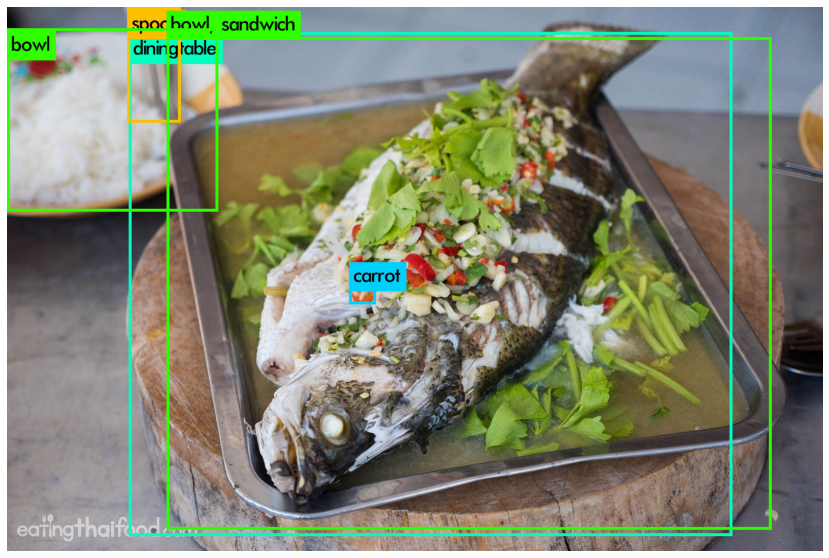

In [0]:
# Not necessary cell
# Execute darknet using YOLOv3 model with pre-trained weights to detect objects on 'person.jpg'
# !./darknet detect cfg/yolov3.cfg ../yolov3.weights data/person.jpg -dont-show
!./darknet detect cfg/yolov3.cfg ../yolov3.weights data/cooked_fish.jpg -dont-show

# Show the result using the helper imgShow()
imShow('predictions.jpg')

## PART 2. STEP 0. Preparing your data and configuration files 

Before going further let's take a look at what configuration files you need to have in your local drive _`darknet`_

![Yolov3 configuration files cheat sheet.jpg](http://blog.ibanyez.info/download/B20190410T000000072.png)

You can download the cheat sheet [here](http://blog.ibanyez.info/download/B20190410T000000072.png)

If you need deeper explanations on how to prepare your data sets, annotation and deep learning, visit [How to train YOLOv3 using Darknet framework and optimize the VM runtime load times](post link)


> **TRICK:** You have to be carefully configuring paths on your config files. _*obj.data*_ file needs to have spaces on the path escaped with _**\**_. Like this: **_/content/gdrive/My\ Drive/darknet/train.txt_**. But, in files **_train.txt_** and **_test.txt_** does not!




## PART 2. STEP 1. Loading files to VM local drive
The network speed between Google Drive and Colab VM can have an impact on your training speed accessing to your dataset images.

You can have 3 possible approaches depending on the size of your dataset. 

> _**NOTE:** This step is not necessary for all the configuration files and weights. They can be accessed directly from Google Drive without considerable performance issues. **This step is only for the dataset images and annotations**_

* **Option 1** - You can try  to use directly the files from Google Drive _`img/`_ folder. Depending on your dataset maybe this can be more than good.
* **Option 2** - Before start training copy your dataset from Google Drive to the local VM filesystem. Maybe can be a good practice to copy as one single tar file and decompress in your VM local _`img/`_ folder
* **Option 3** - If your dataset is quite big, maybe you can upload to a git repository and clone from here. Usually transfer time between are much better. If you have to decide I have the feeling that bitbucket have better speed transfer times than github, but please, don't take this as confirmed, **I haven't done specific tests on that, I could be wrong!** 

#### PART 2. STEP 1 - Option 1. Using files from Google Drive directly.
You don't have to do anything here. Your **_train.txt_** should have the correct path:
* **/content/grdive/My Drive/darknet/img/image001.jpg**. As said before, don't use escaped white space for the paths on _**train.txt**_ and _**test.txt**_

In [0]:
# !cp -r ../src/g_img_dataset/train ../src/g_img_dataset/images/

^C


#### PART 2. STEP 1 - Option 2A. Copying files from Google Drive to VM local filesystem.
Execute the follow cell to copy your files

In [0]:
# Copy fils from Google Drive to the VM local filesystem
# !cp -r "/content/gdrive/My Drive/darknet/img" ./img

#### PART 2. STEP 1 - Option 2B. Copying files zipped from Google Drive to VM local filesystem and unzip locally.
Execute the follow cell to copy your files and uncompress.
You can use _*!ls*_ command to esnure what's the correct path you have to configure in your _*train.txt*_ to correctly access to your dataset images


In [0]:
# Copy your compressed file
#!cp -r "/content/gdrive/My Drive/darknet/img/img.tgz" ./img

# Uncompress zipped file
#!tar -xzvf ./img/img.tgz

#### PART 2. STEP 1 - Option 3. Clone your image dataset from a git repo. Seems the fastest one.
Execute the follow cell to clone your dataset repo to VM local filesystem


In [0]:
# Git clone directly to ./img folder
#!git clone https://[your-repository] ./img

# Check the result - Uncomment when you checked for speed up further runs
#!ls -la ./img

In [0]:
root_path = '/content/gdrive/My Drive/Portfolio_data/Projet-Food-Reconizer/darknet'  #change dir to your project folder
os.chdir(root_path)

In [0]:
# Extract the images dataset
# !jar xvf images.zip

## PART 3. Finally, Train your model!

When you execute the following command, your model will start training.

You will have a log line per epoch. On each iteration you will see how your training is going.

> **TRICK: Darknet copies a backup of your trained weights every 100 iterations. As magic, this file will be synced to your local drive on your computer, as well as the backups darknet do every 1000 iterations, saving it on a separate file.**





In [0]:
# !./darknet detector train "/content/gdrive/My Drive/MyCraftsManShip/Data Science/Portfolio_data/Projet-Food-Reconizer/darknet/food58.data" "/content/gdrive/My Drive/MyCraftsManShip/Data Science/Portfolio_data/Projet-Food-Reconizer/darknet/cfg/yolo-food58.cfg" "/content/gdrive/My Drive/MyCraftsManShip/Data Science/Portfolio_data/Projet-Food-Reconizer/darknet/weights/darknet19_448.conv.23" -dont_show
!./darknet detector train "/content/gdrive/My Drive/MyCraftsManShip/Data Science/Portfolio_data/Projet-Food-Reconizer/darknet/food58-mini.data" "/content/gdrive/My Drive/MyCraftsManShip/Data Science/Portfolio_data/Projet-Food-Reconizer/darknet/cfg/yolo-food58-mini.cfg" "/content/gdrive/My Drive/MyCraftsManShip/Data Science/Portfolio_data/Projet-Food-Reconizer/darknet/weights/darknet19_448.conv.23" -dont_show

yolo-food58-mini
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 max          2 x 2 / 2   416 x 416 x  32   ->   208 x 208 x  32 0.006 BF
   2 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   3 max          2 x 2 / 2   208 x 208 x  64   ->   104 x 104 x  64 0.003 BF
   4 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   5 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   6 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   7 max          2 x 2 / 2   104 x 104 x 128   ->    52 x  52 x 128 0.001 BF
   8 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256 1.595 BF
   9 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  10 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256 1.595 BF
  11 max          2 x 2 / 2    52 x  52 x 256   ->    26 x

In [0]:
# !chmod 777 /content/gdrive/My\ Drive/MyCraftsManShip/Data\ Science/Portfolio_data/Projet-Food-Reconizer/darknet
# /food58.data
# !chmod 777 /content/gdrive/My\ Drive/MyCraftsManShip/Data\ Science/Portfolio_data/Projet-Food-Reconizer/darknet/weights/backup/
# !ls -l weights/ 

total 77472
drwx------ 2 root root     4096 May 11 15:18 backup
-rw------- 1 root root 79327120 Dec 13  2016 darknet19_448.conv.23


In [0]:
# !!!! object-detection-using-yolo-v3-and-deploying-it-on-docker-and-minikube
# https://medium.com/analytics-vidhya/object-detection-using-yolo-v3-and-deploying-it-on-docker-and-minikube-c1192e81ae7a

# https://texas-aerial-robotics.github.io/md_yoloTraining.html

# how-to-train-to-detect-your-custom-objects
# https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects

# Tuto object detection : https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10
# https://www.youtube.com/watch?v=Rgpfk6eYxJA

# FoodTracker: A Real-time Food Detection Mobile Application byDeep Convolutional Neural Networks
# https://arxiv.org/pdf/1909.05994.pdf

# food-detection-app-using-tensorflow-object-detection-apis
# https://blog.goodaudience.com/food-detection-app-using-tensorflow-object-detection-apis-1b9302a9aad2

# How to train YOLOv3 on Google COLAB to detect custom objects (e.g: Gun detection)
# https://medium.com/@quangnhatnguyenle/how-to-train-yolov3-on-google-colab-to-detect-custom-objects-e-g-gun-detection-d3a1ee43eda1

# https://texas-aerial-robotics.github.io/md_yoloTraining.html

In [0]:
!wget -O data/almonds.jpg https://www.bellaviva.com/assets/images/nuts/organic_almonds-1.jpg

--2020-05-11 17:08:25--  https://www.bellaviva.com/assets/images/nuts/organic_almonds-1.jpg
Resolving www.bellaviva.com (www.bellaviva.com)... 198.144.22.77
Connecting to www.bellaviva.com (www.bellaviva.com)|198.144.22.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117203 (114K) [image/jpeg]
Saving to: ‘data/almonds.jpg’

data/almonds.jpg    100%[===================>] 114.46K   216KB/s    in 0.5s    

2020-05-11 17:08:26 (216 KB/s) - ‘data/almonds.jpg’ saved [117203/117203]



layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 max          2 x 2 / 2   416 x 416 x  32   ->   208 x 208 x  32 0.006 BF
   2 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   3 max          2 x 2 / 2   208 x 208 x  64   ->   104 x 104 x  64 0.003 BF
   4 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   5 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   6 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   7 max          2 x 2 / 2   104 x 104 x 128   ->    52 x  52 x 128 0.001 BF
   8 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256 1.595 BF
   9 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  10 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256 1.595 BF
  11 max          2 x 2 / 2    52 x  52 x 256   ->    26 x  26 x 256 0.001 

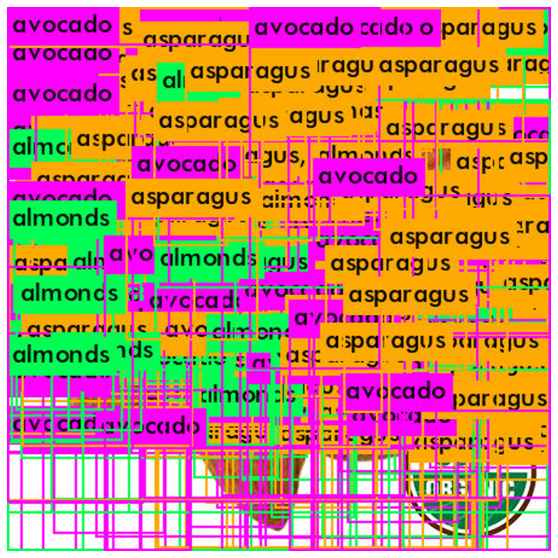

In [0]:
# Execute darknet using YOLOv3 model with pre-trained weights to detect objects on images food test
# !./darknet detect cfg/yolov3.cfg ../yolov3.weights data/person.jpg -dont-show
# !./darknet detect cfg/yolo-food58.cfg weights/backup/yolo-food58_last.weights data/asparagus.jpg -dont-show
# !./darknet detector train "/content/gdrive/My Drive/MyCraftsManShip/Data Science/Portfolio_data/Projet-Food-Reconizer/darknet/food58-mini.data" "/content/gdrive/My Drive/MyCraftsManShip/Data Science/Portfolio_data/Projet-Food-Reconizer/darknet/cfg/yolo-food58.cfg" "/content/gdrive/My Drive/MyCraftsManShip/Data Science/Portfolio_data/Projet-Food-Reconizer/darknet/weights/darknet19_448.conv.23" -dont_show
!./darknet detector test "food58-mini.data" cfg/yolo-food58-mini.cfg weights/backup/yolo-food58_last.weights data/almonds.jpg -dont-show

# Show the result using the helper imgShow()
imShow('predictions.jpg')